# Users Management (`.users`)

Estimated reading time: 10'

## What you'll learn

This guide's objective is to help you get familiarized with PySyft's Users API. You will learn to:
- access, register, update and delete user accounts
- configure the registration options
- update login credentials for user accounts

## User Roles in Syft

There are three types of accounts for a domain:

- **ADMIN** - used for *internal* Datasite administrators and data owners
- **DATA_SCIENTIST** - used for *external* researchers (accessing data)
- **GUEST** - used for *external* users

They are differentiated based on what permissions they have. Here is a permissions table for quick reference:

|                  | **Create Users** | **List Users** | **Update Users** | **Delete Users** |
|------------------|------------------|----------------|------------------|------------------|
| `ADMIN`          |       ✅         |        ✅       |       ✅         |        ✅        |
| `DATA_SCIENTIST` |       🚫         |        🚫       |      ✔️\*         |        🚫        |
| `GUEST`          |       🚫         |        🚫       |      ✔\*         |        🚫        |

\* `DATA_SCIENTIST` and `GUEST` accounts can only update their own information

You can interact with a Datasite through a Syft *client*.

## Account Login

The most straight-forward way to login to a Datasite is by instatiating a client with the `sy.login()` function, which requires an account's credentials (email/password).


```{admonition} Prerequisites
The following code snippets assume you have deployed a Datasite.
```

In [ ]:
import syft as sy

conn = sy.orchestra.launch(name="local_domain", port="auto", dev_mode=False, reset=True)

In [ ]:
import syft as sy

admin_client = sy.login(
    url='localhost',
    port = conn.port,
    email="info@openmined.org",
    password="changethis",
)

An admin can also login as other users or as a guest user.

```python
ds_client = admin_client.login_as('data.scientist@openmined.org')
```

```python
guest_client = admin_client.login_as_guest()
```

### Changing Login Credentials

It's important to change an account's default password (or the password specified when creating the account) as soon as possible. This can be achieved with the `client.account.set_password()` function.

In [ ]:
admin_client.account.set_password('new_password', confirm=False)

This option is available for *every* account type. Additionaly, as an admin, you can change an account's login credentials with the `users.update()` function, detailed below.

## CRUD on Users Profiles

### Create Users

Only `ADMIN` users can create new accounts.

New user accounts can be created via the `client.users.create()` function, which has the following signature:

```python
client.users.create(user_create: UserCreate)
```

The `user_create` parameter is a `UserCreate` object, that will be instantiated with the following arguments:
- `id: str` - automatically generated by PySyft
- `name: str` - the name associated with the new account
- `email: str` - the email address associated with the new account
- `password: str` - the password associated with the new account
- `institution: str (optional)`
- `website: str (optional)`
- `role: ServiceRole` - could be one of `ADMIN`, `GUEST` or `DATA_SCIENTIST` (default)

In [ ]:
from syft.service.user.user import UserCreate, ServiceRole

admin_client.users.create(
    name='John Doe',
    email='new.user@openmined.org',
    password='password',
    role=ServiceRole.DATA_SCIENTIST
)

### See Registered Users

Only `ADMIN` users can list the users available on a Datasite.

You can see a list of registered users on the Datasite through the client object.

In [ ]:
users = admin_client.users
users

You can perform various operations on users by selecting them from the `client.users` object.

In [ ]:
# Select the second user in the list
users[1]

In [ ]:
# Select a user with a specific email
email = 'new.user@openmined.org'

user = [u for u in users if u.email == email][0]
user.name

### Update User Information

Only `ADMIN` users can update _other users_' information. Every user type can update _their own_ information.

A user's information can be updated via the `client.users.update()` function, which has the following signature.

```python
client.users.update(uid: str, user_update: UserUpdate)
```

The `uid` parameter is the ID of the account you want to update.

The `user_udpate` parameter is a `UserUpdate` object, that will be instantiated with the same arguments as `UserCreate`. However, only updated fields need to be specified.

In [ ]:
from syft.service.user.user import UserUpdate, ServiceRole

user = admin_client.users[1]

admin_client.users.update(
    uid=user.id, 
    name='Updated John Doe',
    password='123456789',
    role=ServiceRole.GUEST
)

Every user, regardless of their account type, can update their own information via the `client.account.update()` function.

In [ ]:
# Example
admin_client.account.update(name='Updated Admin')

### Delete Users

`ADMIN` users can delete any other user.

Users can be deleted via the `client.user.delete()` function, which has the following signature:

```python
client.users.delete(uid: str)
```

The `uid` parameter is the ID of the account you want to delete.

In [ ]:
admin_client.users

In [ ]:
user = admin_client.users[1]

admin_client.users.delete(user.id)

In [ ]:
admin_client.users

## Notifications

PySyft can send notifications for various events in the data access/processing workflows. Only email notifications are currently supported, but future versions will include other types of notifications (SMS, Slack etc.).

You can check if the notifications are enabled for your account by inspecting the `client.account.notifications_enabled` object:

In [ ]:
admin_client.account.notifications_enabled

For more details on notifications, such as enabling or disabling them, checkout the [Notifications API guide](./notifications.ipynb)

## Configure Registration Workflow

`ADMIN` users can toggle between two registration workflows:
- **Manual Registration** (default): keep your Datasite private and *manually* add new users
- **Self-Service Registration**: allow your Datasite to be discoverable, so any visitor can create a new `DATA_SCIENTIST` account

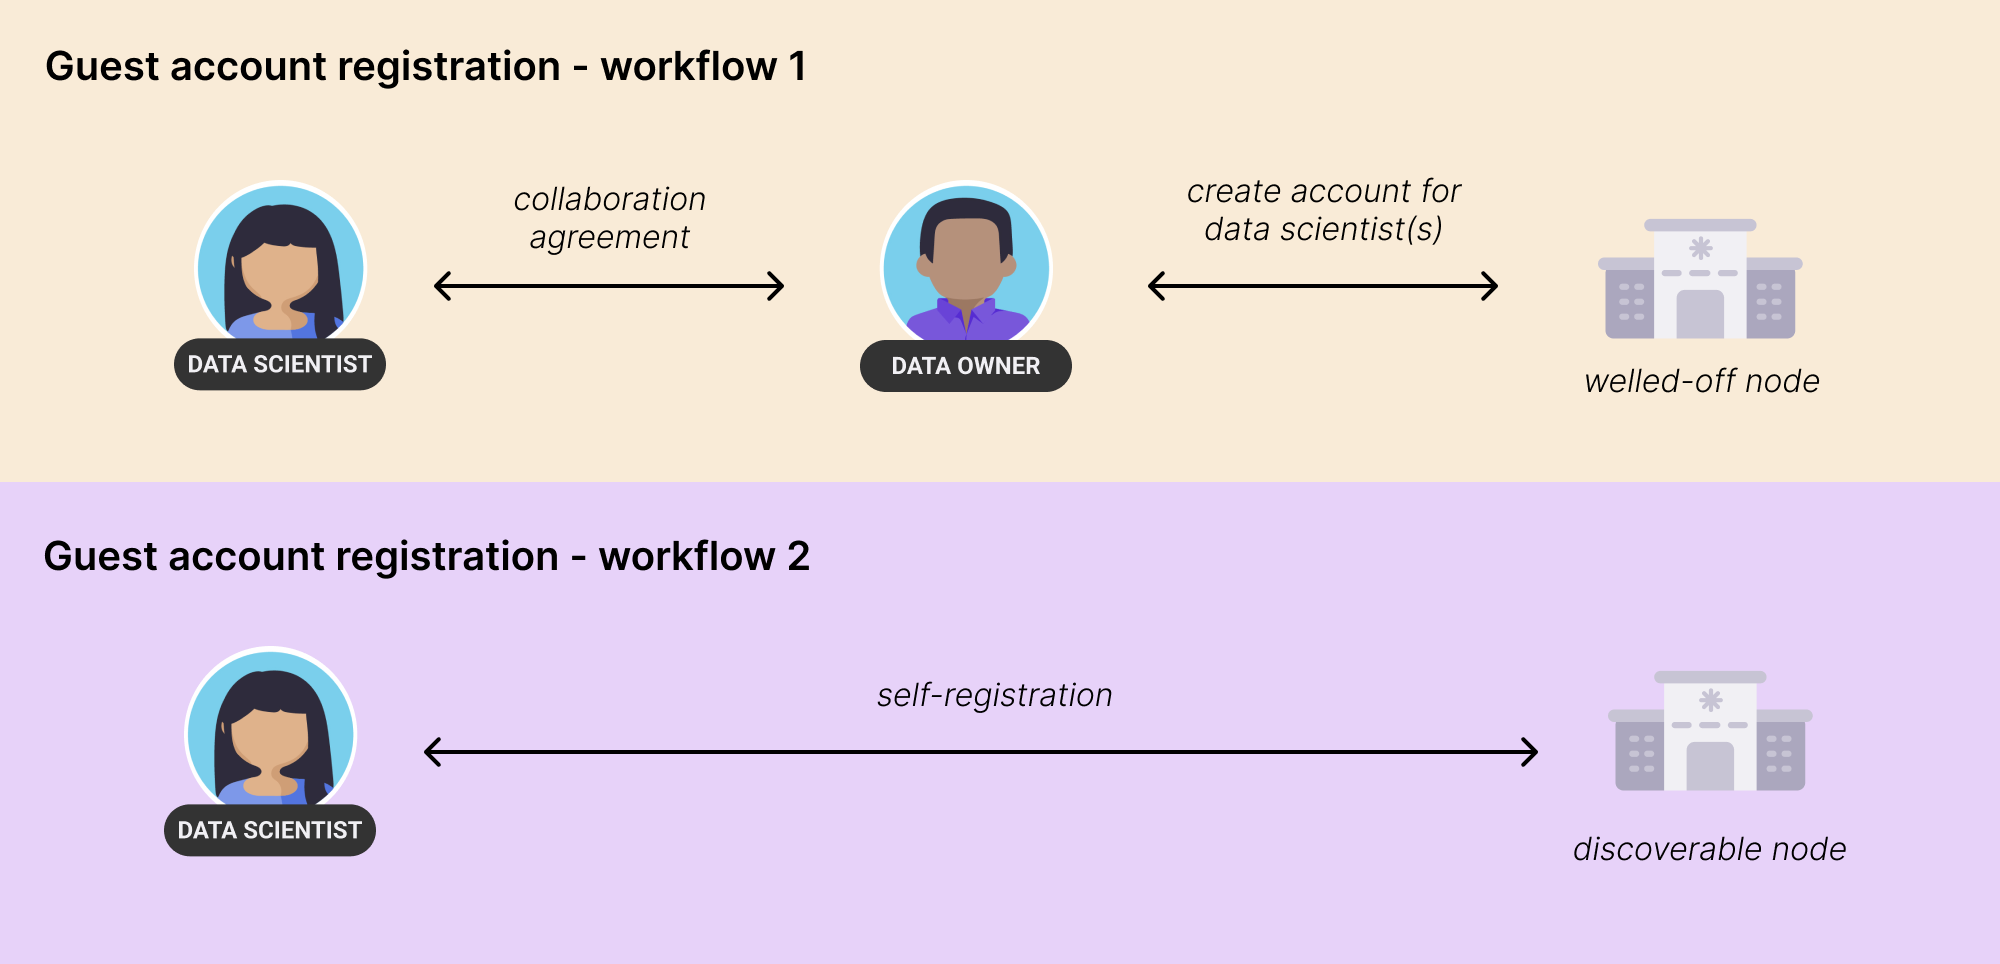

An admin can switch between the two registration workflows via the `client.settings.allow_guest_signup()` function, which has the following signature:

```python
client.settings.allow_guest_signup(enable: bool)
```

When `enable` is set to `False` the workflow switches to **Manual Registration**, and when `enable` is set to `True` the workflow switches to **Self-Service Registration** and the Datasite becomes *discoverable*.

In [ ]:
# Switch to MANUAL registration
admin_client.settings.allow_guest_signup(enable=False)

In [ ]:
# Switch to SELF-SERVICE registration (the Datasite becomes discoverable)
admin_client.settings.allow_guest_signup(enable=True)

When the Datasite is discoverable, the data scientist can connect to the Datasite and register their account with the help of the `domain.register()` function, which takes the following parameters:

- `name: str`
- `email: str`
- `password: str`
- `password_verify: str` - must have the same value as `password`
- `institution: str (optional)`
- `website: str (optional)`

In [ ]:
import syft as sy

# Connect to the discoverable Datasite
discoverable_domain = sy.connect(url='localhost', port=conn.port)

discoverable_domain.register(
    name='Curious Scientist',
    email='data.scientist@institution.org',
    password='data_scientist_password',
    password_verify='data_scientist_password',
)

After registering, a `DATA_SCIENTIST` user is created, which can be accessed through a client.

In [ ]:
admin_client.users

In [ ]:
ds_client = sy.login(
    url='localhost',
    port=conn.port,
    email="data.scientist@institution.org",
    password="data_scientist_password",
)

ds_client